In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import XYZ_to_Lab, delta_E, XYZ_to_RGB, RGB_to_XYZ
from colour.models import RGB_COLOURSPACE_sRGB
import tifffile
import zarr

In [2]:
global_dir = '/uftp/src/'

In [3]:
def get_reverted_gammaCorr(img, gammas):
    # Transpose to set channel as 1st for iter
    _transposed = np.transpose(img, (2, 0, 1))

    # Perform inverse gamma correction
    ret = np.empty_like(_transposed)
    for i, gamma in enumerate(gammas):
        ret[i] = _transposed[i] ** (gamma)

    # Transpose back to original shape
    ret = np.transpose(ret, (1, 2, 0))
    return ret

In [4]:
def calculate_delta_E (self, reference, observe):
    observe = XYZ_to_Lab(observe)
    reference = XYZ_to_Lab(reference)
    deltas = np.zeros((observe.shape[0], 1))
    for i in range(observe.shape[0]):
        a = reference[i, :]
        b = observe[i, :]
        deltas[i] = delta_E(a, b, method="CIE 2000")
    return deltas

In [5]:
def image_read(sector, g1, g2, g3):
  store = tifffile.imread(f'{global_dir}Calib_{sector}_{g1}_{g2}_{g3}_202402.tif', aszarr=True)
  zarr_pyramids = zarr.open(store, mode='r')
  image = np.array(zarr_pyramids[3])/255
  image_revert = get_reverted_gammaCorr(image,[(g1/10),(g2/10),(g3/10)])
  return image_revert

In [6]:
def coords_read(sz):
  return pd.read_csv(f'{global_dir}saved_coords/manual/huron0224/{sz}um_coords.csv')

In [7]:
images = {
    "R1_111": image_read("R1", 10, 10, 10)
}
rads = {"4150":40, "1000":10, "750":6, "500":4, "400":4, "300":2, "250":2, "200":1, "150":1, "CA1000":50}
coords = {"4150":coords_read(4150),
          "1000":coords_read(1000),
          "750":coords_read(750),
          "500":coords_read(500),
          "400":coords_read(400),
          "300":coords_read(300),
          "250":coords_read(250),
          "200":coords_read(200),
          "150":coords_read(150),
          "CA1000":coords_read("CA1000")}
number_of_circles = 24

<tifffile.TiffPage 6 @11318147692> missing data offset tag


In [8]:
def draw_circle_mask(image, coord, radius):
  mask_shape = image.shape
  coords_y, coords_x = np.ogrid[: mask_shape[0], : mask_shape[1]]
  circle_mask = np.zeros(mask_shape[:2], dtype=bool)
  for idx, centroids in coord.iterrows():
      centroid_y, centroid_x = centroids["Y"], centroids["X"]
      circle_mask = circle_mask | ((coords_y - centroid_y) ** 2 + (coords_x - centroid_x) ** 2 <= radius**2)

  plt.imshow(image)
  plt.imshow(circle_mask, alpha=0.5)

In [9]:
def create_circle_mask(image, centroids, radius):
    mask_shape = image.shape[:2]
    coords_y, coords_x = np.ogrid[: mask_shape[0], : mask_shape[1]]
    circle_mask = (coords_y - centroids["Y"])**2 + (coords_x - centroids["X"])**2 <= radius**2
    circle_mask = np.expand_dims(circle_mask, axis=-1)  # Add a channel dimension
    circle_mask = np.tile(circle_mask, (1, 1, image.shape[2]))  # Tile to match image channels
    return circle_mask

In [10]:
def calc_rectangle(image, coord, radius):
    #create an array of mean values of one set of circles from A1 to D6
    mean_values = []
    for idx, centroids in coord.iterrows():
        circle = create_circle_mask(image, centroids, radius)
        masked_image = image * circle
        mean_in_circle = []
        for i in range(image.shape[2]):
            channel_values = masked_image[:,:,i][masked_image[:,:,i] != 0]
            mean_in_circle.append(channel_values.mean())
        mean_in_circle = np.nan_to_num(mean_in_circle)  # Replace NaN with 0
        mean_values.append(mean_in_circle.tolist())
    return np.array(mean_values)

None


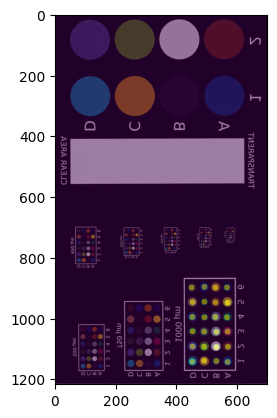

In [11]:
print(draw_circle_mask(images["R1_111"], coords["1000"], rads["1000"]))

In [12]:
def calc_rectangles(image, coords, rads, zones):
  #calculates mean value of all mean values from A1 to D6 in one single image
  mean_values = np.zeros((number_of_circles,image.shape[2]))
  for idx, v in enumerate(zones):
    mean_values = mean_values + calc_rectangle(image, coords[v], rads[v])
  mean_values = mean_values/(idx+1)
  return mean_values

In [13]:
def calc_slide(mnval_CA, mnval_slide):
  #appends clear area colors value to the beginning of data array
  #thus formating in standart form: [CA, A1, ..., D6].
  full_table = np.append(mnval_CA, mnval_slide, axis=0)
  return full_table

In [14]:
CA = calc_rectangle(images["R1_111"],
               coords["CA1000"],
               rads["CA1000"])
slide = calc_rectangles(images["R1_111"],
                        coords,
                        rads,
                        zones = ["1000", "750", "500", "400", "300", "250", "200", "150"])

/tmp/ipykernel_36475/2390175713.py:10: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
from rawparser import RawDataParser
from circlelib import CircleColors
rw = RawDataParser(reference_basepath = f'{global_dir}calibration_data/')
circ = CircleColors()

In [16]:
colour_arrays = {
    "exp_srgbs": calc_slide(CA,slide),
    "exp_xyz": RGB_to_XYZ(calc_slide(CA,slide), RGB_COLOURSPACE_sRGB), #not correct
    "ref_srgbs": rw.get_reference_srgbs(),
    "ref_xyz": rw.get_reference_d65()
}

In [17]:
from regressors import *

In [18]:
PLS_reg = PLSRegressor(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"])
Lasso_reg = LassoRegressor(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"], 0.01)

In [20]:
images["HS1 PLS reg"] = PLS_reg.predict(images["R1_111"])
images["HS1 Lasso reg"] = Lasso_reg.predict(images["R1_111"])

In [22]:
CA = calc_rectangle(images["HS1 PLS reg"],
               coords["CA1000"],
               rads["CA1000"])
slide = calc_rectangle(images["HS1 PLS reg"],
               coords["1000"],
               rads["1000"])
colour_arrays["PLS_reg_srgbs"] = calc_slide(CA,slide)
CA = calc_rectangle(images["HS1 Lasso reg"],
               coords["CA1000"],
               rads["CA1000"])
slide = calc_rectangle(images["HS1 Lasso reg"],
               coords["1000"],
               rads["1000"])
colour_arrays["Lasso_reg_srgbs"] = calc_slide(CA,slide)

/tmp/ipykernel_36475/2390175713.py:10: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


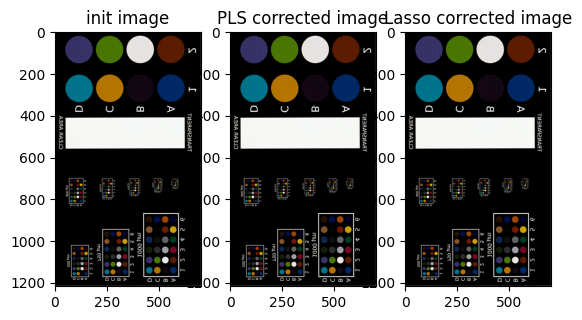

In [24]:
name_list = [["R1_111", "init image"],
             ["HS1 PLS reg", "PLS corrected image"],
             ["HS1 Lasso reg", "Lasso corrected image"]]

f, axarr = plt.subplots(1,3)
for i, vector in enumerate(name_list):
  axarr[i].imshow(images[vector[0]])
  axarr[i].set_title(vector[1])

In [25]:
np.mean(circ.calculate_delta_E(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"]))

21.43061952411399

In [26]:
np.mean(circ.calculate_delta_E(colour_arrays["PLS_reg_srgbs"], colour_arrays["ref_srgbs"]))

22.07711729510174

In [27]:
np.mean(circ.calculate_delta_E(colour_arrays["Lasso_reg_srgbs"], colour_arrays["ref_srgbs"]))

22.07711729510174